In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import math
import os.path
from os.path import join
import numpy as np
import imodelsx
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import scipy.stats
import imodelsx.viz
import json
import seaborn as sns
import data
import joblib
from matplotlib.gridspec import GridSpec
from scipy.stats import spearmanr
LEVELS = ['Very Negative', 'Negative', 'Neutral',
          'No response', 'Positive', 'Very Positive']
files_dict = data.load_files_dict_single_site()

[2024-03-09 09:07:03,168] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


success: 18
fail: ['Cincinnati', 'Columbus']


### Filter data for single-site analysis

In [2]:
# checkpoint = 'meta-llama/Llama-2-7b-hf'
# checkpoint = 'meta-llama/Llama-2-70b-hf'
checkpoint = 'gpt-4'  # gpt-35-turbo
# checkpoint = 'gpt-35-turbo'
# checkpoint = 'mistralai/Mistral-7B-v0.1'


# site = 'Atlanta'
# site = 'Columbus'
# site = 'WashingtonDC'
site = 'Charlotte'  # Houston, Portland
df = files_dict[site]
qs, responses_df, themes_df = data.split_single_site_df(df)

### Run sentiment
Note: this uses a lot of API calls (num questions * num responses), maybe around 400

In [3]:
def run_sentiment(site, checkpoint, qs, responses_df, themes_df, llm=None):
    sentiment_prompt = '''### You are given a question and a response. Rate the sentiment/supportiveness of the response on a scale of 1 to 5, where 1 is very negative and 5 is very positive. ###

Question: {question}

Response: {response}

Rating (1-5):'''
    if llm is None:
        llm = imodelsx.llm.get_llm(checkpoint, repeat_delay=None)

    num_questions = len(qs)
    sentiments = defaultdict(list)
    for question_num in tqdm(range(num_questions), position=0):
        question, responses, theme_dict = data.get_data_for_question_single_site(
            question_num=question_num, qs=qs, responses_df=responses_df, themes_df=themes_df)

        for response_num in tqdm(range(len(responses)), position=1):
            response = responses.values[response_num]

            if pd.isna(response):
                sentiments[question_num].append(np.nan)
            else:
                prompt = sentiment_prompt.format(
                    question=question, response=response)
                ans = llm(prompt)
                sentiments[question_num].append(ans)

    # save
    pd.DataFrame(sentiments).T.to_pickle(
        join(data.PROCESSED_DIR, f'sentiments_df_{site}_{checkpoint.split("/")[-1]}.pkl'))
    return sentiments


def compute_and_save_sent_df(sentiments, site, checkpoint):

    sent_df = pd.DataFrame([(key, var) for (key, L) in sentiments.items() for var in L],
                           columns=['Question', 'Value'])

    # round  values
    sent_df['Value'] = sent_df['Value'].astype(float).round()
    value_maps = {
        1: 'Very Negative',
        2: 'Negative',
        3: 'Neutral',
        4: 'Positive',
        5: 'Very Positive',
    }
    sent_df['Value'] = sent_df['Value'].map(value_maps.get)
    sent_df['Value'] = sent_df['Value'].fillna('No response')

    sent_df = sent_df.groupby(
        ['Question', 'Value']).size().unstack(fill_value=0)
    sent_df = sent_df.reindex(LEVELS, axis=1)
    if checkpoint == 'gpt-4':
        joblib.dump(sent_df, join(data.PROCESSED_DIR,
                    f'sent_df_{site}_gpt-4.pkl'))
    return sent_df

# run single
# sentiments = run_sentiment(site, checkpoint, qs, responses_df, themes_df)


# run all sites
llm = imodelsx.llm.get_llm(checkpoint, repeat_delay=20)
# ['Atlanta', 'Columbus', 'WashingtonDC']:
# for site in ['Charlotte', 'Houston', 'Portland']:
for site in ['Dallas', 'Seattle', 'Tucson']:
    df = files_dict[site]
    qs, responses_df, themes_df = data.split_single_site_df(df)
    sentiments = run_sentiment(
        site, checkpoint, qs, responses_df, themes_df, llm=llm)
    sent_df = compute_and_save_sent_df(sentiments, site, checkpoint)

  0%|          | 0/46 [00:00<?, ?it/s]/home/chansingh/pedidose-efic-analysis/notebooks/data.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  resp = responses[i]
100%|██████████| 11/11 [00:00<00:00, 7570.95it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5064.47it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 7179.79it/s]


cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5568.11it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5847.57it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5749.20it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5752.07it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 7206.71it/s]


cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5815.88it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6420.45it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 7234.96it/s]


cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 10211.90it/s]


cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6037.34it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 15618.60it/s]


cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 7373.72it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 7516.67it/s]


cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6097.18it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5720.69it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6217.13it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 9982.12it/s]


cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6228.88it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


 48%|████▊     | 22/46 [00:00<00:00, 218.55it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6634.65it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5997.31it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5932.54it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5967.06it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5882.61it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6024.72it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6057.95it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5914.29it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5900.67it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 9644.09it/s]


cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 7595.87it/s]


cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5883.36it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 8032.27it/s]


cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6312.40it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6279.75it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6220.49it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6415.98it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6282.32it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5686.14it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6525.79it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6620.37it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6381.38it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


 98%|█████████▊| 45/46 [00:00<00:00, 224.38it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 46/46 [00:00<00:00, 223.58it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


  0%|          | 0/46 [00:00<?, ?it/s]/home/chansingh/pedidose-efic-analysis/notebooks/data.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  resp = responses[i]
100%|██████████| 10/10 [00:00<00:00, 6784.70it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 5889.22it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 10/10 [00:00<00:00, 6458.74it/s]


cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 5900.82it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 4683.23it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 10/10 [00:00<00:00, 4751.68it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 4942.03it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 10/10 [00:00<00:00, 4505.64it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 4737.19it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 6411.35it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 6386.94it/s]


cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 6488.71it/s]


cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 4203.97it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 10/10 [00:00<00:00, 4362.25it/s]


cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 5818.15it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 6789.10it/s]


cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 9965.08it/s]


cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 7707.28it/s]


cached!
cached!
cached!
cached!


cached!


100%|██████████| 10/10 [00:00<00:00, 4239.67it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 6424.11it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 4912.51it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


 48%|████▊     | 22/46 [00:00<00:00, 212.86it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 4286.46it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 3770.16it/s]


cached!
cached!


cached!


100%|██████████| 10/10 [00:00<00:00, 4180.93it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 10/10 [00:00<00:00, 4404.39it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 4322.24it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 4949.62it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 6775.94it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 5210.96it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 6253.62it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 5059.47it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 8156.95it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 10/10 [00:00<00:00, 4270.75it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 10/10 [00:00<00:00, 4142.93it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 4897.60it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 6385.00it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 4898.17it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 5125.00it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 5306.56it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 6526.07it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 10/10 [00:00<00:00, 4727.57it/s]


cached!


 96%|█████████▌| 44/46 [00:00<00:00, 209.46it/s]

cached!
cached!
cached!
cached!
cached!
cached!


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 46/46 [00:00<00:00, 209.02it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


  0%|          | 0/46 [00:00<?, ?it/s]/home/chansingh/pedidose-efic-analysis/notebooks/data.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  resp = responses[i]
100%|██████████| 11/11 [00:00<00:00, 7850.49it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!



100%|██████████| 11/11 [00:00<00:00, 12046.30it/s]


cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 7124.36it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6266.96it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5129.79it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6117.39it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 7402.11it/s]

cached!
cached!
cached!
cached!
cached!
cached!



100%|██████████| 11/11 [00:00<00:00, 6219.65it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5315.97it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 7261.15it/s]


cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 7543.71it/s]


cached!
cached!
cached!
cached!
cached!


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 7099.15it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!



100%|██████████| 11/11 [00:00<00:00, 7505.67it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!



100%|██████████| 11/11 [00:00<00:00, 6463.62it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!



100%|██████████| 11/11 [00:00<00:00, 6248.29it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5837.95it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 11/11 [00:00<00:00, 4544.66it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!



100%|██████████| 11/11 [00:00<00:00, 7449.92it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 4206.92it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!
cached!


 48%|████▊     | 22/46 [00:00<00:00, 219.61it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6947.35it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 11/11 [00:00<00:00, 4978.67it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6066.71it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 11/11 [00:00<00:00, 5129.22it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6132.84it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 11/11 [00:00<00:00, 5084.00it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 11/11 [00:00<00:00, 4568.96it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 11/11 [00:00<00:00, 4552.28it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 11/11 [00:00<00:00, 4877.61it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6769.97it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6723.60it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6141.00it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6289.17it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5953.21it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5364.18it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5954.74it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 11/11 [00:00<00:00, 4675.45it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 11/11 [00:00<00:00, 4358.75it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6067.51it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5553.36it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5960.13it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6970.44it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!



100%|██████████| 11/11 [00:00<00:00, 6844.29it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!



100%|██████████| 46/46 [00:00<00:00, 216.59it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


### Plot sentiment

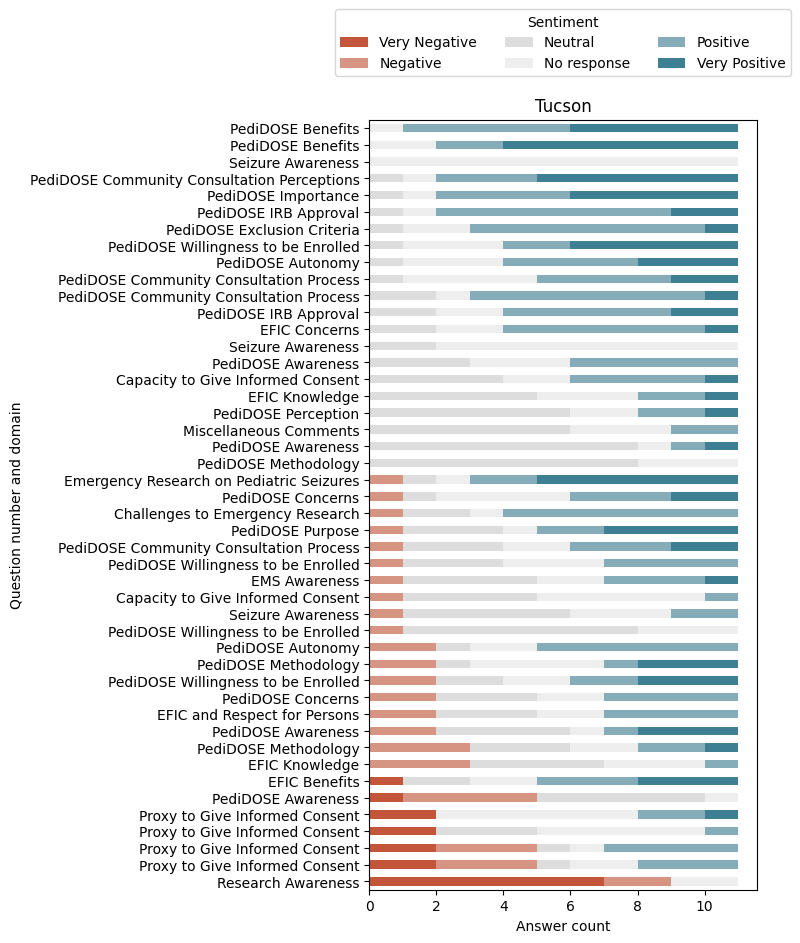

In [4]:
# make plot
sent_df = compute_and_save_sent_df(sentiments, site, checkpoint)
sent_df = sent_df.sort_values(by=LEVELS, ascending=False)
colors = sns.diverging_palette(20, 220, n=6).as_hex()
colors = colors[:2] + ['#ddd', '#eee'] + colors[-2:]
sent_df.plot(kind='barh', stacked=True, figsize=(5, 10), color=colors)

plt.yticks(range(46), labels=df['Domain'].values[sent_df.index.values])
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncol=3, title='Sentiment')
plt.xlabel('Answer count')
plt.ylabel('Question number and domain')
plt.title(site)
plt.savefig(f'../figs/eda/sentiment_example_{site}.pdf', bbox_inches='tight')
plt.show()

### Aggregate sentiment plots

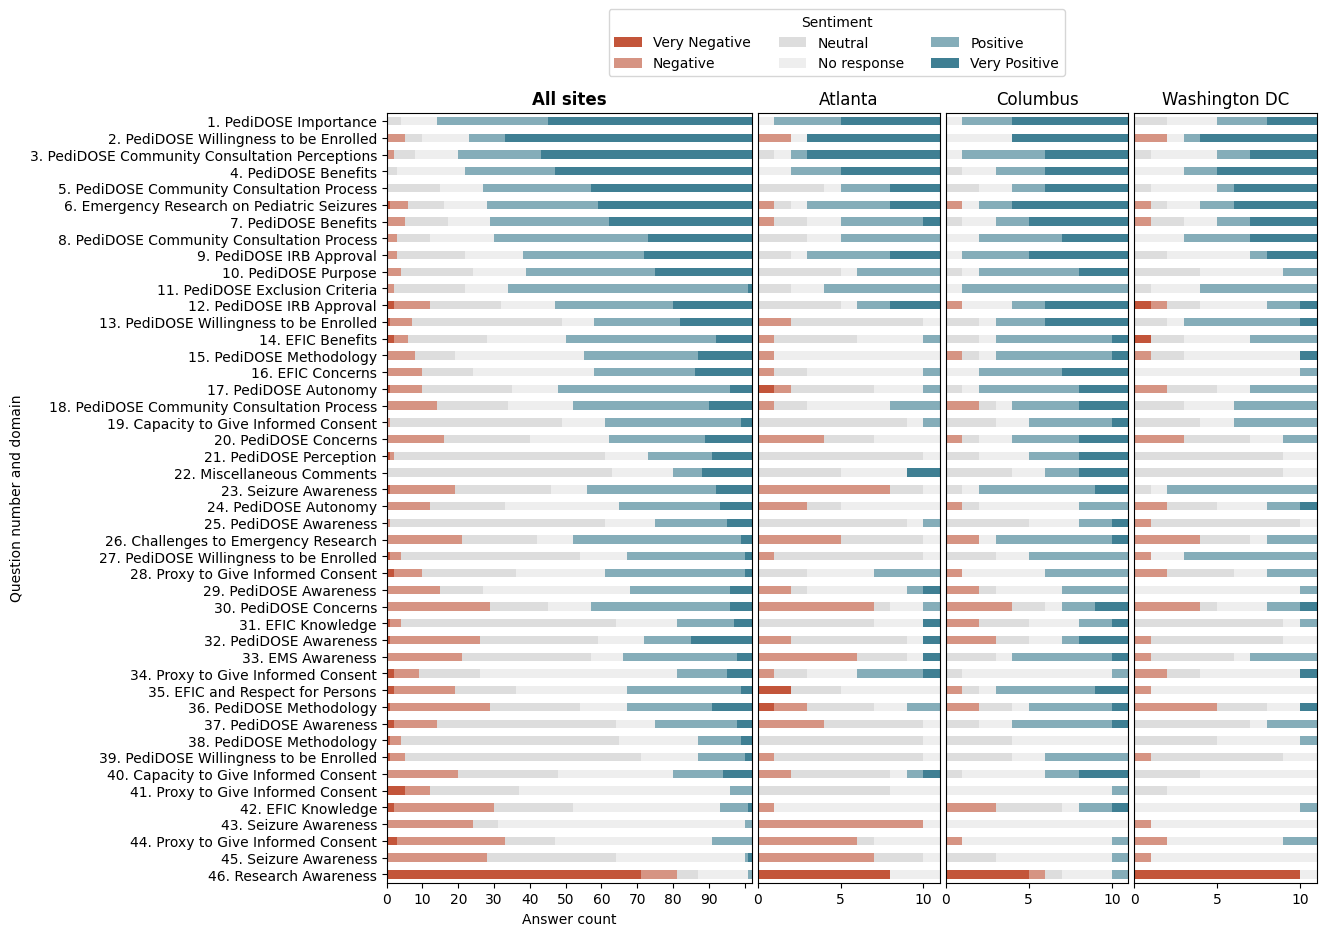

In [5]:
sent_dfs = []
#
sites = ['Atlanta', 'Columbus', 'WashingtonDC'] + \
    ['Charlotte', 'Houston', 'Portland'] + \
    ['Dallas', 'Seattle', 'Tucson']
for site in sites:
    sent_df = joblib.load(
        join(data.PROCESSED_DIR, f'sent_df_{site}_gpt-4.pkl'))
    # sent_df = sent_df.sort_values(by=levels, ascending=False)
    sent_dfs.append(sent_df)

sum_df = pd.concat(sent_dfs).groupby(level=0).sum()

# make plot
# sum_df = sum_df.sort_values(by=LEVELS, ascending=False)
# sum_index_sorted = sum_df.index
mean = -2 * sum_df['Very Negative'] + -1 * sum_df['Negative'] + \
    1 * sum_df['Positive'] + 2 * sum_df['Very Positive']
sum_index_sorted = mean.sort_values().index
sum_df = sum_df.reindex(sum_index_sorted)

colors = sns.diverging_palette(20, 220, n=6).as_hex()
colors = colors[:2] + ['#ddd', '#eee'] + colors[-2:]

fig = plt.figure(figsize=(12, 10))
gs = GridSpec(1, 4, width_ratios=[2, 1, 1, 1], wspace=0.025)


# first plot
ax1 = fig.add_subplot(gs[0])
sum_df.plot(kind='barh', stacked=True, color=colors, ax=ax1, legend=False)
plt.xlim(0, sum_df.sum(axis=1).max())
# remove label for final xtick
labels = [str(i) if i % 10 == 0 else '' for i in range(
    0, int(sum_df.sum(axis=1).max()) + 1, 10)]
labels[-1] = ''
plt.xticks(range(0, int(sum_df.sum(axis=1).max()) + 1, 10),
           labels=labels)
plt.yticks(range(46),
           labels=[f'{len(sent_df) - i}. {v}' for i, v in enumerate(
               df['Domain'].values[sum_df.index.values])])
fig.legend(bbox_to_anchor=(0.5, 0.95), loc='center', ncol=3, title='Sentiment')
plt.xlabel('Answer count')
plt.title('All sites', fontweight='bold')
plt.ylabel('Question number and domain')

sites_examples = ['Atlanta', 'Columbus', 'WashingtonDC']
for i, site in enumerate(sites_examples):
    ax = fig.add_subplot(gs[i+1])
    sent_df = sent_dfs[i]
    sent_df = sent_df.reindex(sum_index_sorted)
    sent_df.plot(kind='barh', stacked=True, color=colors, ax=ax, legend=False)
    plt.xlim(0, sent_df.sum(axis=1).max())
    plt.yticks([])
    plt.ylabel('')
    plt.title(data.RENAME_SITE_DICT.get(site, site))
plt.savefig(f'../figs/sentiment_agg.pdf', bbox_inches='tight')
plt.savefig(f'../figs/sentiment_agg.png', bbox_inches='tight', dpi=300)
plt.show()

In [6]:
len(df['Domain'].value_counts())

25

In [7]:
total_responded = sum_df.sum().sum() - sum_df['No response'].sum().sum()
print(total_responded, 'responses', sum_df['No response'].sum(), 'no response')
print('breakdown', sum_df.sum(), round((100 * sum_df.sum() / total_responded)))

3692 responses 1000 no response
breakdown Value
Very Negative     104
Negative          482
Neutral          1207
No response      1000
Positive         1191
Very Positive     708
dtype: int64 Value
Very Negative     3.0
Negative         13.0
Neutral          33.0
No response      27.0
Positive         32.0
Very Positive    19.0
dtype: float64


In [8]:
# no limit display
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    d = df.iloc[sum_index_sorted][::-1][['Domain', 'Subcategory']]
    d['Question order'] = d.index
    d.insert(loc=0, column='Question number', value=np.arange(1, len(d) + 1))
    # display(d)
    d.to_csv('../figs/question_list.csv', index=False)

# Human annotation

**Select questions**

In [18]:
# # original function filter 10 questions that have many themes (these tend to be more interesting)
# # select questions
# def get_num_themes(df):
#     num_themes_list = []
#     for question_num in range(len(df)):
#         question, responses, theme_dict = data.get_data_for_question_single_site(
#             question_num=question_num, qs=qs, responses_df=responses_df, themes_df=themes_df)
#         num_themes_list.append(len(theme_dict))
#     return np.array(num_themes_list)
#     # df['num_themes'] = num_themes_list
#     # return df


# num_themes = np.zeros(46)
# SITES = ['Atlanta', 'Columbus', 'WashingtonDC']
# for site in sites:
#     df = files_dict[site]
#     num_themes += get_num_themes(df)
# idx = pd.Series(num_themes).sort_values(ascending=False)
# questions_selected = idx.index[:10]

# instead pick 3 most positive, 3 middle, and 3 most negative
mid = 46 // 2
sorted_qs = list(sum_index_sorted)
questions_selected = sorted_qs[:3] + sorted_qs[mid-1:mid+2] + sorted_qs[-3:]

# save these questions
pd.Series(questions_selected).to_csv(
    '../figs/human/sentiment_questions_selected.csv', index=False, header=False)

**Select random answers to questions (up to 15 per question)**

In [10]:
# read in responses from all sites
resps_dict = defaultdict(list)
for question_num in questions_selected:
    for site in ['Atlanta', 'Columbus', 'WashingtonDC']:
        df = files_dict[site]
        question, responses, theme_dict = data.get_data_for_question_single_site(
            question_num=question_num, qs=qs, responses_df=responses_df, themes_df=themes_df)
        resps_dict[question_num] += list(responses)
assert np.all(np.array(list(len(v) for v in resps_dict.values())) == 33)


# randomly select up to 15 non-nan responses for each question and record their indices (less if there are fewer than 15)
rng = np.random.default_rng(13)
resps_idx_selected = defaultdict(list)
resps_selected = {}
for question_num in questions_selected:
    resps = resps_dict[question_num]
    indices = np.arange(33)[~pd.isna(resps)]
    indices_selected = rng.choice(
        indices, size=min(len(indices), 15), replace=False).tolist()
    resps_idx_selected[question_num] = indices_selected
    resps_selected[question_num] = [resps[i] for i in indices_selected]

# put into a big defaultdict
dd = defaultdict(list)
for question_num in questions_selected:
    for i, resp in enumerate(resps_selected[question_num]):
        dd['Question number'].append(question_num)
        dd['Response number'].append(resps_idx_selected[question_num][i])

        dd['Question'].append(qs[question_num])
        dd['Response'].append(resp)

# dump
with open('../figs/human/sentiment_idx_selected.json', 'w') as f:
    json.dump(resps_idx_selected, f, indent=4)
ddf = pd.DataFrame.from_dict(dd)
ddf.to_csv('../figs/human/sentiment_template.csv', index=False)
ddf.to_pickle('../figs/human/sentiment_template.pkl')

/home/chansingh/pedidose-efic-analysis/notebooks/data.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  resp = responses[i]


### Analyze human results

In [24]:
annots = {
    'hum1': 'human1',
    'hum2': 'human2',
    'hum3': 'human3',
}

# template = pd.read_pickle('../figs/human/sentiment_template.pkl')
template = pd.read_csv('../figs/human/sentiment_template.csv')
for k, v in annots.items():
    hum = pd.read_csv(f'../figs/human/collected/sentiment_{v}.csv', skiprows=1)

    def remove_all_whitespace(s):
        return ''.join(s.split())

    # check for matching index, value range
    assert hum.shape[0] == template.shape[
        0], f'Shape mismatch for {k}: {hum.shape[0]} vs {template.shape[0]}'
    assert np.all(hum['Response number'].astype(str).apply(remove_all_whitespace).values ==
                  template['Response number'].astype(str).apply(remove_all_whitespace).values), f'Error for hum {k}'

    # add col
    template[k] = hum['Rating'].values.astype(int)
    assert np.all(template[k].values >= 1)
    assert np.all(template[k].values <= 5)

checkpoints_all = [
    'gpt-4', 'gpt-35-turbo',
    'meta-llama/Llama-2-70b-hf',
    'meta-llama/Llama-2-7b-hf',
    'mistralai/Mistral-7B-v0.1',  # 'mistralai/Mixtral-8x7B-v0.1'
]


def find_starting_number(s):
    # if s starts with a number or a number with decimal places, return that number
    # otherwise return nan
    s = str(s).strip()
    if s == 'nan':
        return np.nan
    ans = ''
    while len(s) > 0 and (s[0].isdigit() or s[0] == '.'):
        ans += s[0]
        s = s[1:]
    return float(ans) if len(ans) > 0 else np.nan


for checkpoint in checkpoints_all:
    sites = ['Atlanta', 'Columbus', 'WashingtonDC']
    sent_dfs = []
    for site in sites:
        sent_df = joblib.load(join(
            data.PROCESSED_DIR, f'sentiments_df_{site}_{checkpoint.split("/")[-1]}.pkl'))
        sent_dfs.append(sent_df)

    sent_dfs[0].columns = np.arange(0, 11)
    sent_dfs[1].columns = np.arange(11, 22)
    sent_dfs[2].columns = np.arange(22, 33)
    sent_llm_full = pd.concat(sent_dfs, axis=1).values
    template[checkpoint] = template.apply(
        lambda row: sent_llm_full[row['Question number'], row['Response number']], axis=1)
    template[checkpoint] = template[checkpoint].apply(find_starting_number)
llms_to_ensemble = ['gpt-4', 'gpt-35-turbo',
                    'mistralai/Mistral-7B-v0.1',  # 'meta-llama/Llama-2-70b-hf',
                    # 'mistralai/Mixtral-8x7B-v0.1',
                    ]

template['Human ensemble'] = template[['hum1', 'hum2', 'hum3']].mean(axis=1)
template = template.rename(columns={
    'hum1': 'Human 1',
    'hum2': 'Human 2',
    'hum3': 'Human 3',
})


template.columns = list(map(lambda x: imodelsx.viz.CHECKPOINTS_RENAME_DICT.get(
    x, x), template.columns))
checkpoints_all = list(map(lambda x: imodelsx.viz.CHECKPOINTS_RENAME_DICT.get(
    x, x), checkpoints_all))
llms_to_ensemble = list(map(lambda x: imodelsx.viz.CHECKPOINTS_RENAME_DICT.get(
    x, x), llms_to_ensemble))
template['LLM ensemble'] = template[llms_to_ensemble].mean(axis=1)

In [25]:
# make sure to apply this across all llms
notna = np.ones(len(template), dtype=bool)
for ckpt in checkpoints_all:
    notna &= template[ckpt].apply(find_starting_number).notna()
print('num annots', notna.sum())

checkpoints_all_hum = ['Human 1', 'Human 2', 'Human 3', 'Human ensemble'] + \
    ['LLM ensemble'] + checkpoints_all
corr = np.zeros((len(checkpoints_all_hum), len(checkpoints_all_hum)))
for r, cr in enumerate(checkpoints_all_hum):
    for c, cc in enumerate(checkpoints_all_hum):
        x = template[cr][notna]
        y = template[cc][notna]
        corr[r, c] = np.corrcoef(x, y)[0, 1]  # spearmanr(x, y)

# convert to df

# labels[0] = 'Human 1'
# labels[1] = 'Human 2'
# labels[2] = 'Human 3'
labels = checkpoints_all_hum
print(labels, corr.shape)
corr_df = pd.DataFrame(corr,
                       index=labels,
                       columns=labels)

# sort by corr with human
ind = corr_df.sort_values(by='Human ensemble', ascending=False).index
ind.values[:4] = ['Human 1', 'Human 2', 'Human 3', 'Human ensemble']
corr_df = corr_df.reindex(ind)[ind]

# Replace correlations with Human ensemble by excluding the human
cols = ['Human 1', 'Human 2', 'Human 3']
hum_corrs = []
for i, c in enumerate(cols):
    avg_excluding_c = template[[col for col in cols if col != c]].mean(axis=1)
    hum_corrs.append(np.corrcoef(
        template[c][notna], avg_excluding_c[notna])[0, 1])
# print(hum_corrs)
corr_df.loc[cols, 'Human ensemble'] = hum_corrs
corr_df.loc['Human ensemble', cols] = hum_corrs

# Replace correlations with LLM ensemble by excluding the LLM
cols = list(map(lambda x: imodelsx.viz.CHECKPOINTS_RENAME_DICT.get(
    x, x), llms_to_ensemble))
llm_corrs = []
for i, c in enumerate(cols):
    avg_excluding_c = template[[col for col in cols if col != c]].mean(axis=1)
    llm_corrs.append(np.corrcoef(
        template[c][notna], avg_excluding_c[notna])[0, 1])
# print(llm_corrs)
corr_df.loc[cols, 'LLM ensemble'] = llm_corrs
corr_df.loc['LLM ensemble', cols] = llm_corrs

num annots 105
['Human 1', 'Human 2', 'Human 3', 'Human ensemble', 'LLM ensemble', 'GPT-4', 'GPT-3.5 Turbo', 'LLAMA-2 (70B)', 'LLAMA-2 (7B)', 'Mistral (7B)'] (10, 10)


In [26]:
corr_df

,Human 1,Human 2,Human 3,Human ensemble,LLM ensemble,Mistral (7B),GPT-3.5 Turbo,GPT-4,LLAMA-2 (70B),LLAMA-2 (7B)
Human 1,1.000000,0.813302,0.850014,0.845929,0.674831,0.628237,0.629419,0.666271,0.611110,0.390150
Human 2,0.813302,1.000000,0.935228,0.915878,0.753336,0.720208,0.728837,0.700558,0.545697,0.587531
Human 3,0.850014,0.935228,1.000000,0.941113,0.694328,0.685594,0.671014,0.622333,0.479559,0.499455
Human ensemble,0.845929,0.915878,0.941113,1.000000,0.741484,0.712082,0.710005,0.692323,0.565113,0.521138
LLM ensemble,0.674831,0.753336,0.694328,0.741484,1.000000,0.884074,0.897027,0.880430,0.761605,0.647003
Mistral (7B),0.628237,0.720208,0.685594,0.712082,0.884074,1.000000,0.863246,0.843401,0.680759,0.595427
GPT-3.5 Turbo,0.629419,0.728837,0.671014,0.710005,0.897027,0.863246,1.000000,0.859109,0.696456,0.640929
GPT-4,0.666271,0.700558,0.622333,0.692323,0.880430,0.843401,0.859109,1.000000,0.794939,0.614289
LLAMA-2 (70B),0.611110,0.545697,0.479559,0.565113,0.761605,0.680759,0.696456,0.794939,1.000000,0.492324
LLAMA-2 (7B),0.390150,0.587531,0.499455,0.521138,0.647003,0.595427,0.640929,0.614289,0.492324,1.000000


In [27]:
def r_confidence_interval(r, alpha, n):
    def _r_to_z(r):
        return math.log((1 + r) / (1 - r)) / 2.0

    def _z_to_r(z):
        e = math.exp(2 * z)
        return ((e - 1) / (e + 1))

    z = _r_to_z(r)
    se = 1.0 / math.sqrt(n - 3)
    z_crit = scipy.stats.norm.ppf(1 - alpha/2)  # 2-tailed z critical value

    lo = z - z_crit * se
    hi = z + z_crit * se

    # Return a sequence
    return (_z_to_r(lo), _z_to_r(hi))


print('interval human-LLM', r_confidence_interval(0.741484, 0.05, 123))
print('interval annotators', np.mean([0.813302, 0.850014, 0.935228]), r_confidence_interval(
    np.mean([0.813302, 0.850014, 0.935228]), 0.05, 123))

interval human-LLM (0.6497397813107971, 0.8119369043715575)
interval annotators 0.8661813333333334 (0.8139632397582225, 0.904514021486069)


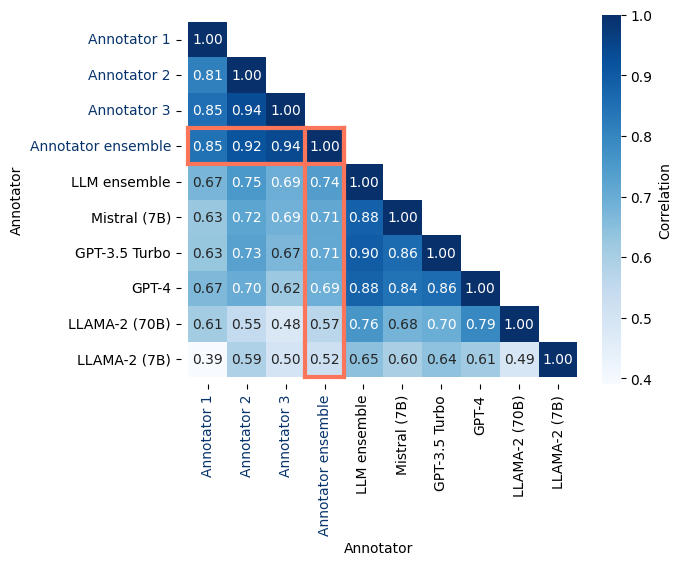

In [28]:
# corr_df = corr_df.iloc[1:, 1:]
mask = np.triu(np.ones_like(corr_df, dtype=bool))
mask[np.diag_indices_from(mask)] = False

rename = {
    'Human 1': 'Annotator 1',
    'Human 2': 'Annotator 2',
    'Human 3': 'Annotator 3',
    'Human ensemble': 'Annotator ensemble',
}
corr_df = corr_df.rename(columns=rename, index=rename)
ax = sns.heatmap(
    corr_df,
    annot=True, fmt='.2f',
    cmap=sns.color_palette("Blues", as_cmap=True), cbar_kws={'label': 'Correlation'},
    mask=mask,
)

# outline the first row of the elements in the heatmap
color = '#fa755a'
lw = 3
roffset = 3.5
coffset = 0.5
shape = corr_df.shape
r = 0
# color = 'gray'
alpha = 1
for c in range(3, shape[1]):
    rx = r + roffset
    cx = c + coffset
    if c == 2:
        plt.plot([rx - 0.5, rx + 0.5],
                 [cx - 0.5, cx - 0.5], color=color, lw=lw, alpha=alpha)
    if c == shape[1] - 1:
        plt.plot([rx - 0.5, rx + 0.5],
                 [cx + 0.5, cx + 0.5], color=color, lw=lw, alpha=alpha)
    plt.plot([rx - 0.5, rx - 0.5],
             [cx - 0.5, cx + 0.5], color=color, lw=lw, alpha=alpha)
    plt.plot([rx + 0.5, rx + 0.5],
             [cx - 0.5, cx + 0.5], color=color, lw=lw, alpha=alpha)

roffset = 0.5
coffset = 0.5
c = 3
for r in range(0, 4):
    kwargs = {
        'color': color,
        'lw': lw,
        # 'linestyle': '-',
        # 'marker': 'None',
        # 'alpha': 0.5,
    }
    rx = r + roffset
    cx = c + coffset
    # if c == 2:
    plt.plot([rx - 0.5, rx + 0.5],
             [cx - 0.5, cx - 0.5], **kwargs)
    # if c == shape[1] - 1:
    plt.plot([rx - 0.5, rx + 0.5],
             [cx + 0.5, cx + 0.5], **kwargs)
    if r == 0:
        plt.plot([rx - 0.5, rx - 0.5],
                 [cx - 0.5, cx + 0.5], **kwargs)
    if r == 3:
        plt.plot([rx + 0.5, rx + 0.5],
                 [cx - 0.5, cx + 0.5], **kwargs)

# set the color of first three xticklabels and yticklabels to blue
for i, t in enumerate(ax.get_xticklabels()):
    if i < 4:
        t.set_color('#08346c')
for i, t in enumerate(ax.get_yticklabels()):
    if i < 4:
        t.set_color('#08346c')


plt.xlim(-.2, shape[0])
plt.ylim(shape[1] + 0.2, -.2)
plt.ylabel('Annotator')
plt.xlabel('Annotator')
plt.savefig('../figs/sentiment_correlation.pdf', bbox_inches='tight')
plt.savefig('../figs/sentiment_correlation.png', bbox_inches='tight', dpi=300)
plt.show()

In [31]:
vals = corr_df.loc['Annotator ensemble', [
    'Annotator 1', 'Annotator 2', 'Annotator 3']]
print('Human ensemble vs human', vals.mean(), vals.sem(ddof=0))

Human ensemble vs human 0.9009734538364448 0.023245471642889984


In [32]:
x1 = template['LLM ensemble'][notna]
x2 = template['Human ensemble'][notna]

# calculate pearson correlation and error of the corr
corr = np.corrcoef(x1, x2)[0, 1]
err = np.sqrt((1 - corr**2) / (len(x1) - 2))
print('LLM ensemble vs human ensemble corr', corr, 'err', err)

LLM ensemble vs human ensemble corr 0.7414839183953142 err 0.06611270156604171


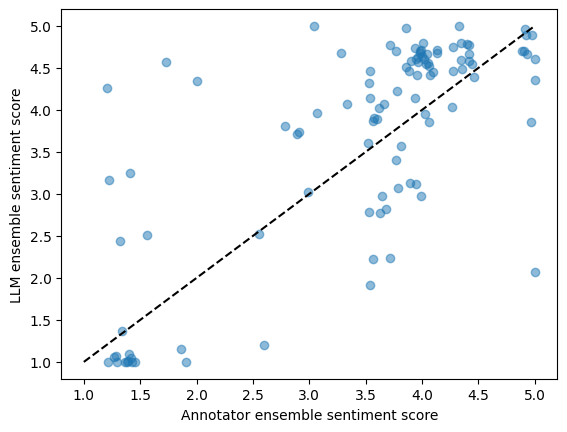

In [54]:
# plot with some jitter
def jitter(values, j, min=1, max=5):
    values = values + np.random.uniform(-j, j, values.shape)
    return np.clip(values, min, max)


x = template['Human ensemble']
y = template['LLM ensemble']
plt.plot(jitter(x, 0.15), jitter(y, 0.15), 'o', alpha=0.5)
plt.xlabel('Annotator ensemble sentiment score')
plt.ylabel('LLM ensemble sentiment score')

plt.plot([1, 5], [1, 5], 'k--')